$\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}$ 
# Quantum PCA to price financial derivates related to DAX index

We will implement an effective [qPCA](https://arxiv.org/abs/1307.0401) algorithm to price financial derivites related to the [DAX German stock index](https://en.wikipedia.org/wiki/DAX) based on the paper [Towards Pricing Financial Derivatives with an IBM Quantum Computer](https://arxiv.org/pdf/1904.05803.pdf). The objective of this algorithm is to approximate a square matrix $M$ of dimension $n$ with a new $\rho$ matrix which will have rank $r << n$, so we need to calculate efficiently the $r$ greatest eigenvalues of the original matrix $M$ as then $\rho = \sum_{i=1}^{r} \lambda_{i} \ket{u_{i}}{} \bra{u_{i}}{}$ with $\lambda_{i}$ being the eigenvalues.

## Calculating the covariance matrix

We first calculate the covariance matrix from the data related to the DAX, this is the matrix we want to reduce calculating its principal components. 

In [127]:
import pandas as pd

url = "https://raw.githubusercontent.com/ibonreinoso/qiskit-hackathon-bilbao-19/master/DAX_PERFORMANCE_INDEX.csv"
data = pd.read_csv(url, sep=';')
data = data.drop(['wkn_500340'], axis = 1)
data = data.loc[:,['wkn_515100', 'wkn_575200']]

covariance_matrix = np.cov(data.values.T)

In [128]:
print(covariance_matrix)

[[ 67.38376849  97.4907718 ]
 [ 97.4907718  152.27294829]]


## Classical approach to the problem

Once the covariance matrix $M$ has been obtained, in a classical PCA algorithm we will have to calculate the eigenvalues. This can be done by calculating the [characteristic polynomial](https://en.wikipedia.org/wiki/Characteristic_polynomial) as it follows:

$$ P(\lambda) = det(M - \lambda Id) $$ 

Where the eigenvalues are the values $\lambda$ such that $P(\lambda) = 0$. The complexity of this operations are bounded by the complexity cost of computing a determinant of the covariance matrix. For our particular case, eigenvalues can be obtained classically as it follows:

In [129]:
# Calculate the characteristic polynomial of the covariance matrix
polynomial = np.poly(covariance_matrix)
# Calculate the roots of the polynomial which are the eigenvalues
eigenvalues = np.roots(polynomial)

print(eigenvalues)

[216.15800524   3.49871154]


As you might have noticed, there is an eigenvalue $\lambda_{max}$ which greater than the other and also $\lambda_{max} = \lambda_{1} >> \lambda_{2}$. Note that this is important in order to carry out effectively a PCA. 

## First step into the quantum model: calculate a unitary matrix

We could instead of calculating the determinant of the matrix, which is highly costly, use quantum computing to outperform the classical approach. To achieve this we will need to modify the covariance matrix so it is turned into an unitary matrix which fits as a quantum gate. This quantum gate will be used perform operations which will help us to obtain the eigenvalues. Later on we will represent the eigenvalues with qubits, so we need them to be in the range $[0,1]$. To achieve this, we will normalize the covariance matrix with respect to its trace (in a $N\times N$ matrix the sum of all the eigenvalues equals the trace, so if we normalize with respect to its trace we will end up with eigenvalues falling in the range we wanted to). 

In [132]:
trace_normalize_matrix = covariance_matrix /np.matrix.trace(covariance_matrix)

print(trace_normalize_matrix)

[[0.30676853 0.44383242]
 [0.44383242 0.69323147]]


Now, we have to create an unitary matrix $U$ from our normalize matrix $N$. This can be done by just taking the complex exponential value of the matrix:

$$ U = e^{2\pi i N} $$


In [134]:
from scipy.linalg import expm

unitary = expm(2*1j*np.pi*trace_normalize_matrix)

print(unitary)

[[9.94996262e-01+0.03988286j 2.19878137e-16-0.09160674j]
 [2.24840803e-16-0.09160674j 9.94996262e-01-0.03988286j]]


## Eigenvectors and eigenvalues 

As when using PCA we assume that there is an eigenvalue $\lambda_{max} = \lambda_{1} >> \lambda_{2}$ then we can use a number of qubits to approximate the value of this eigenvalues. In this notebook we will focus on the implementation with just two qubits, but further investigation on how to generalize this model could be carried out. We will initialize a qubit in a random state and try to change its value until it reaches the value of the eigenvector which corresponds to the eigenvalue $\lambda_{max}$. So, the initial state of the vector will be:

$$ \ket{b} = \frac{\ket{0}{} + \ket{1}{}}{\sqrt{2}} $$

If the value of $\ket{b}$ was the actual eigenvector of the eigenvalue $\lambda_{max}$ we are over, but it is not. Nevertheless, we can use the [Quantum Amplitude Estimation](https://arxiv.org/abs/quant-ph/0005055) to estimate the eigenvector of the matrix $U$. Once this calculation has been performed the data can be retrived by using the [Quantum Fourier Transform](https://en.wikipedia.org/wiki/Quantum_Fourier_transform). This process can be repited in order to obtain a more precise value of the eigenvalue. Here we present this approach step by step:

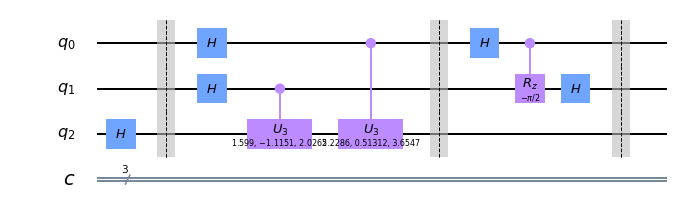

In [143]:
# We will draw the first iteration circuit:
from qiskit import *

num_qubits_eigenvalue = 2
num_qubits_eigenvector = 1
num_qubits = num_qubits_eigenvalue + num_qubits_eigenvector

quantum_circuit = QuantumCircuit(num_qubits, num_qubits)

# Create the random state for |b>
quantum_circuit.h(2)
quantum_circuit.barrier()


# We perform quantum amplitude estimation with the unitary matrix U
quantum_circuit.h(0)
quantum_circuit.h(1)
# Calculate the gate which relates to the unitary matrix 
(th1, ph1, lam1) = qiskit.quantum_info.synthesis.two_qubit_decompose.euler_angles_1q(expm(2*1j*np.pi*rho2))
quantum_circuit.cu3(th1, ph1, lam1, 1, 2)
# Calculate the gate which relates to the unitary matrix applied two times, which is necessary for Quantum Amplitude Estimation
(th2, ph2, lam2) = qiskit.quantum_info.synthesis.two_qubit_decompose.euler_angles_1q(expm(2*1j*np.pi*rho2*2))
quantum_circuit.cu3(th2, ph2, lam2, 0, 2)
quantum_circuit.barrier()

# Now we perform the quantum fourier transform in the first two qubits
quantum_circuit.h(0)
quantum_circuit.crz(-np.pi/2,0,1)
quantum_circuit.h(1)
quantum_circuit.barrier()

quantum_circuit.draw(output = 'mpl')

## A deep look at the iterative process

After the Quantum Fourier Transformation is performed, the state of the whole system will be (it is remarkable that this state depends on the initial random state $\ket{b}$ so we explicitly denote it):

$$ \ket{\Phi_{b}} = \sum_{i=0}^{3} \frac{1}{\sqrt{2}} \ket{\lambda_{i}} \otimes \ket{u_{i}} $$

We obtain a state where eigenvectors and eigenvalues are entangled. So, if one of the eigenvalues is greater than the other, then by projecting in the related eigenvalue based component of the state $\ket{\Phi_{b}}$ one can efficiently obtain the value of the eigenvector. In order to do it, we now perform a measurement and calculate the data projected to the state $\ket{11}$ which corresponds surely to the highest eigenvalue.

After the first iteration results are showed below:

In [145]:
# We perform some measurements on the circuit
quantum_circuit.measure([0,1,2],[0,1,2])

# Let execute the circuit on the quantum simulator
results = execute(quantum_circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=1024).result().get_counts()

# Count the states related to the 11 projection
denominator_result = results['111'] + results['011']

# Calculate the coefficient of the eigenvector 
alpha1 = np.sqrt(results['011'] / denominator_result)
alpha2 = np.sqrt(results['111'] / denominator_result)

# Eigenvector coefficents are showed
print(alpha1, alpha2)

0.9354143466934853 0.3535533905932738


## A complete implementation of the qPCA

We are now able to implement the Quantum Principal Component Analysis algorithm by taking the value calculated at each iteration and reusing it as the initial quantum state of the random vector $\ket{b}$:


In [146]:
# We initialize the random vector b to H|0> = 1/sqrt(2) * (|0> + |1>) 
state_vector = [1/np.sqrt(2), 1/np.sqrt(2)]

# We establish a limit to the number of iteration and a bound to the accuracy
limit_iteration = 100

for i in range(0, 100):
    quantum_circuit = QuantumCircuit(NUM_QUBITS, NUM_QUBITS)
    quantum_circuit.initialize(state_vector, NUM_QUBITS-1)
    quantum_circuit.h(0)
    quantum_circuit.h(1)
    (th1, ph1, lam1) = qiskit.quantum_info.synthesis.two_qubit_decompose.euler_angles_1q(expm(2*1j*np.pi*rho2))
    quantum_circuit.cu3(th1, ph1, lam1, 1, 2)
    (th2, ph2, lam2) = qiskit.quantum_info.synthesis.two_qubit_decompose.euler_angles_1q(expm(2*1j*np.pi*rho2*2))
    quantum_circuit.cu3(th2, ph2, lam2, 0, 2)
    quantum_circuit.h(0)
    quantum_circuit.crz(-np.pi/2,0,1)
    quantum_circuit.h(1)
    quantum_circuit.measure([0,1,2],[0,1,2])
    results = execute(quantum_circuit, backend=backend, shots=SHOTS_PER_ITERATION).result().get_counts()
    denominator_result = results['111'] + results['011']
    alpha1 = np.sqrt(results['011'] / denominator_result)
    alpha2 = np.sqrt(results['111'] / denominator_result)
    new_state = [alpha1, alpha2]
    state_vector = new_state
